# Código TFG

### **Sincronización con Google Drive**

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
path_to_folder = '/content/drive/My Drive/TFG'
os.chdir(path_to_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Librerías**

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from scipy.optimize import minimize
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import random
import string

### **Lectura de la base de datos**

In [ ]:
df=pd.read_csv("Prueba_50.csv")
df.head()

,Nodes;Node Degree
0,10;2
1,15;3
2,8;4
3,17;5


### **Funciones definidas**

Identificador de un lista llena de ceros

In [ ]:
def lista_llena_de_ceros(lista):
    # Itera sobre cada elemento de la lista
    for elemento in lista:
        # Si encuentra un elemento que no es cero, devuelve False
        if elemento != 0:
            return False
    # Si no encuentra ningún elemento distinto de cero, devuelve True
    return True

Función Objetivo

In [ ]:
#Definimos una función objetivo que se encarga de calcular la suma de los cuadrados de las diferencias entre las distancias actuales y las distancias deseadas
def objective(pos, edges, desired_distances):
    pos = pos.reshape((len(G.nodes), 2)) #Convertimos pos a dos dimensiones
    diff = 0
    for idx, (u, v) in enumerate(edges): #Vamos calculando la distancia euclidea actual, para calcular la suma de los cuadrados de las diferencias entre las distancias actuales y las distancias deseadas
        actual_distance = euclidean(pos[u-1], pos[v-1])
        diff += (actual_distance - desired_distances[idx]) ** 2
    return diff

Calculadora de las distancias de las aristas

In [ ]:
# Función para calcular y devolver las distancias actuales de las aristas
def calculate_edge_distances(G, pos):
    distances = {}
    for u, v in G.edges():
        dist = euclidean(pos[u], pos[v])
        distances[(u, v)] = dist
    return distances

Ajuste de porcentajes

In [ ]:
def ajustar_porcentajes(num_nodos, lista):

  stop = 0
  stop2 = 0
  #value = 0
  #index = 0

  lista2 = [num*num_nodos for num in lista]
  print(lista2)

  # Encontrar los índices de los resultados que originalmente llevaban decimales
  decimales = []
  for num in lista2:
    if num != int(num):
      decimales.append(num-int(num))

  # Redondear los resultados a números enteros
  resultados_enteros = [int(round(num)) for num in lista2]
  print(resultados_enteros)
  # Calcular la suma de los resultados enteros
  suma_resultados_enteros = sum(resultados_enteros)

  # Calcular la diferencia entre la suma de los resultados enteros y num_nodos
  diferencia = num_nodos - suma_resultados_enteros


  # Determinar si la diferencia no es cero y hay resultados con decimales
  if diferencia != 0:
      if diferencia > 0:
        lista_ordenada= sorted(decimales, reverse=True) #Ordenamos la lista de mayor a menor
        for n in lista_ordenada:
          if (n <= 0.5) and (stop == 0):
            stop = 1
            value = n


        for m in range(len(decimales)):
          if (value == decimales[m]) and (stop2 == 0):
            index = m
            stop2 = 1


        resultados_enteros[index] =  resultados_enteros[index]+1

      else:
        lista_ordenada= sorted(decimales) #Ordenamos la lista de menor a mayor
        for n in lista_ordenada:
          if (n >= 0.5) and (stop == 0):
            stop = 1
            value = n


        for m in range(len(decimales)):
          if (value == decimales[m]) and (stop2 == 0):
            index = m
            stop2 = 1


        resultados_enteros[index] =  resultados_enteros[index]-1

  return resultados_enteros

Camino alternativo para cada arista

In [ ]:
def has_alternative_path_for_each_edge(G):
    for edge in G.edges():
        G.remove_edge(*edge)  # Eliminamos la conexión actual -> *edge descomprime la tupla edge en sus dos nodos
        if not nx.has_path(G, edge[0], edge[1]):  # Verificamos si hay un camino alternativo
            G.add_edge(*edge)  # Volvemos a añadir la conexión
            return False
        G.add_edge(*edge)  # Volvemos a añadir la conexión
    return True

Camino alternativo para cada nodo

In [ ]:
def has_alternative_path_for_each_node(G):
    nodes = list(G.nodes())  # Crear una copia de la lista de nodos para que no nos de error
    for node in nodes: #Recorremos todos los nodos
        neighbors = list(G.neighbors(node))  # Guardar los vecinos del nodo
        G.remove_node(node)  # Eliminar el nodo actual
        subgraph_is_connected = nx.is_connected(G)  # Verificar si el subgrafo es conexo
        G.add_node(node)  # Volver a añadir el nodo
        for neighbor in neighbors:
            G.add_edge(node, neighbor)  # Restaurar las conexiones originales
        if not subgraph_is_connected:
            return False
    return True

### **Generador de topologías aleatorias**

182


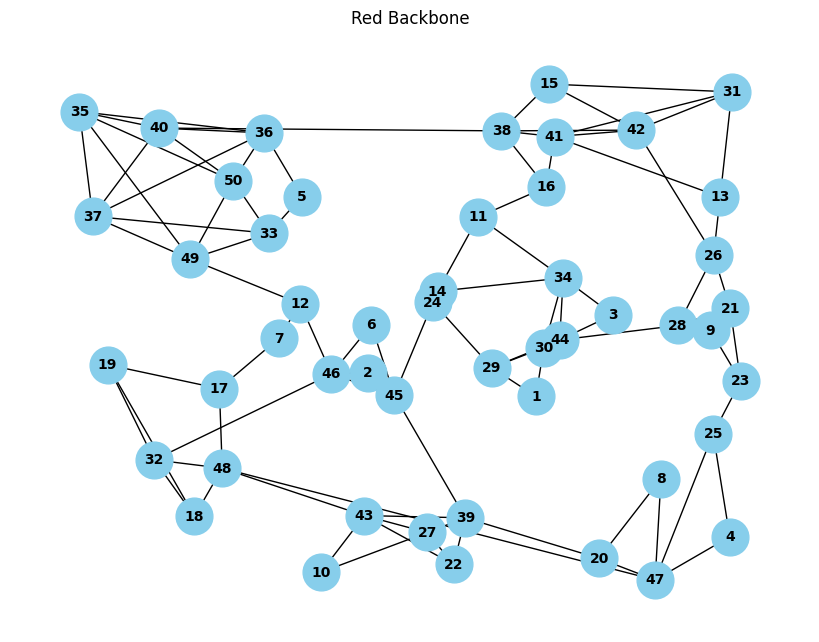

In [ ]:

num_nodos=0
finish=0
count = 0


select_node = 0 # Variable para seleccionar nodo con menos conexiones : Al principio la ponemos vacía
lista_nodo1 = []
lista_nodo2 = []

num_total_conexiones = 0

for indice, fila in df.iterrows():
    fila_lista = fila.iloc[0].split(';')
    nodos = fila_lista[0]
    conexiones = fila_lista[1]
    num_nodos += int(nodos)

conexiones_pendientes = np.zeros(num_nodos)

#Asignar las conexiones que tiene que hacer cada nodo -> rellenamos la lista conexiones_pendientes
for indice, fila in df.iterrows():
    fila_lista = fila.iloc[0].split(';')
    nodos = fila_lista[0]
    conexiones = fila_lista[1]

    #Recorremos el numero de nodos para las conexiones indicadas
    for j in range(int(nodos)):
      conexiones_pendientes[count] = int(conexiones)
      count += 1
      num_total_conexiones += int(conexiones)

print(num_total_conexiones)
conexiones_pend  = conexiones_pendientes.copy()

while True:
  distancias = [] #donde vamos a ir almacenando las distancias en una lista de tuplas
  pos = {nodo: np.random.rand(2) for nodo in range(1, num_nodos + 1)} #almacenamos los datos en un diccionario
  lista_pos = list(pos.items()) #cambiamos los datos de las posiciones de donde se encuentra cada nodo a lista de tuplas
  conexiones_pendientes = conexiones_pend.copy()
  conexiones_realizadas = [None]*num_nodos #donde vamos a almacenar los nodos a los que se conecta cada nodo
  G = nx.Graph()
  for l in range(int(num_total_conexiones/2)):
    select_distance = 1
    select = 1
    select_node = 0
    finish = 0
    distancias = []

    # 1. Buscamos el nodo con mas conexiones pendientes por hacer
    for i in range(num_nodos):
      if (conexiones_pendientes[i]>conexiones_pendientes[select_node]):
        select_node = i


    # 2. Recorremos el número total de nodos para rellenar las distancias con ese nodo
    for k in range(num_nodos):
      if(k!=select_node): #No hacemos la distancia con el mismo nodo
        distancias.append((k+1, np.linalg.norm(lista_pos[select_node][1]-lista_pos[k][1]))) #añadimos la distancia euclidea


    # 3. Recorremos la lista con todas las distancias para elegir el nodo al que conectarse
    for m in range(len(distancias)):
      no = 0
      if (distancias[m][1] < select_distance): #si la distancia que estamos mirando es menor la seleccionamos
        tupla_buscar = conexiones_realizadas[select_node]
        if(tupla_buscar is not None):
          for n in tupla_buscar:
            if(n==(distancias[m][0]-1)):
              no = 1
        if(conexiones_pendientes[distancias[m][0]-1]==0):
          no = 1

        if ((no==0)):
          select = distancias[m][0] #Seleccionamos el nodo al que nos conectamos
          select_index = m #Antes lo utilizabamos para eliminar de la lista de distancias
          select_distance = distancias[m][1] #Distancia menor seleccionada
          finish=1


    if (finish==1):

      if (conexiones_realizadas[select-1] is not None):
        lista_nodo1 = list(conexiones_realizadas[select-1])
      lista_nodo1.append(select_node)
      tupla1 = tuple(lista_nodo1)
      conexiones_realizadas = list(conexiones_realizadas)
      conexiones_realizadas[select-1] = tupla1

      if (conexiones_realizadas[select_node] is not None):
        lista_nodo2 = list(conexiones_realizadas[select_node])
      lista_nodo2.append(select-1)
      tupla2 = tuple(lista_nodo2)
      conexiones_realizadas = list(conexiones_realizadas)
      conexiones_realizadas[select_node] = tupla2

      conexiones_pendientes[select-1] -=1
      conexiones_pendientes[select_node] -=1
      #print(conexiones_pendientes)

      lista_nodo1 = []
      lista_nodo2 = []

      #print(conexiones_realizadas)
      #hacemos la conexion en la gráfica
      G.add_edge(lista_pos[select_node][0], select)
      #print(G)
      select_distance = 1
      select = 1
      finish = 0

      distancias = []

  # Cortamos el bucle cuando se hayan hecho todas las conexiones y exista supervivencia
  if ((lista_llena_de_ceros(conexiones_pendientes) == True) & (nx.is_connected(G) == True) & (has_alternative_path_for_each_edge(G) == True) & (has_alternative_path_for_each_node(G) == True)):
    break

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold', edge_color='black')
plt.title("Red Backbone")
plt.show()

### **Supervivencia eliminando conexiones**

In [ ]:
is_connected = nx.is_connected(G)

# Definimos la función para ver que cada conexión tiene otra alternativa
def has_alternative_path_for_each_edge(G):
    for edge in G.edges():
        G.remove_edge(*edge)  # Eliminamos la conexión actual -> *edge descomprime la tupla edge en sus dos nodos
        if not nx.has_path(G, edge[0], edge[1]):  # Verificamos si hay un camino alternativo
            G.add_edge(*edge)  # Volvemos a añadir la conexión
            return False
        G.add_edge(*edge)  # Volvemos a añadir la conexión
    return True

if is_connected:
    # Verificamos si cada arista tiene un camino alternativo
    alternative_paths_exist = has_alternative_path_for_each_edge(G)
    if alternative_paths_exist:
        print("El grafo es robusto ante la falla de cualquier conexión y no hay nodos aislados.")
    else:
        print("El grafo no es robusto ante la falla de cualquier conexión.")
else:
    print("El grafo tiene nodos aislados o no es conexo.")

El grafo es robusto ante la falla de cualquier conexión y no hay nodos aislados.


### **Supervivencia eliminando nodos**

In [ ]:
is_connected = nx.is_connected(G)

# Definimos la función para ver que cada nodo tiene otra alternativa
def has_alternative_path_for_each_node(G):
    nodes = list(G.nodes())  # Crear una copia de la lista de nodos para que no nos de error
    for node in nodes: #Recorremos todos los nodos
        neighbors = list(G.neighbors(node))  # Guardar los vecinos del nodo
        G.remove_node(node)  # Eliminar el nodo actual
        subgraph_is_connected = nx.is_connected(G)  # Verificar si el subgrafo es conexo
        G.add_node(node)  # Volver a añadir el nodo
        for neighbor in neighbors:
            G.add_edge(node, neighbor)  # Restaurar las conexiones originales
        if not subgraph_is_connected:
            return False
    return True

if is_connected:
    # Verificamos si cada arista tiene un camino alternativo
    alternative_paths_exist = has_alternative_path_for_each_node(G)
    if alternative_paths_exist:
        print("El grafo es robusto ante la falla de cualquier nodo y no hay nodos aislados.")
    else:
        print("El grafo no es robusto ante la falla de cualquier nodo.")
else:
    print("El grafo tiene nodos aislados o no es conexo.")

El grafo es robusto ante la falla de cualquier nodo y no hay nodos aislados.


### **Adaptación de los nodos a la distancia deseada**

[18.2, 27.3, 9.1, 22.75, 13.65]
[18, 27, 9, 23, 14]
91.0
182
[18, 27, 9, 23, 14]
91
91
Distancia entre los nodos (34, 3): 6.00
Distancia entre los nodos (34, 44): 6.00
Distancia entre los nodos (34, 30): 6.00
Distancia entre los nodos (34, 11): 6.00
Distancia entre los nodos (34, 14): 6.00
Distancia entre los nodos (3, 44): 6.00
Distancia entre los nodos (35, 40): 4.77
Distancia entre los nodos (35, 36): 7.71
Distancia entre los nodos (35, 50): 5.49
Distancia entre los nodos (35, 37): 5.49
Distancia entre los nodos (35, 49): 6.00
Distancia entre los nodos (40, 36): 4.77
Distancia entre los nodos (40, 50): 6.72
Distancia entre los nodos (40, 37): 6.72
Distancia entre los nodos (40, 38): 6.00
Distancia entre los nodos (36, 50): 5.49
Distancia entre los nodos (36, 37): 5.49
Distancia entre los nodos (36, 5): 6.00
Distancia entre los nodos (50, 49): 7.00
Distancia entre los nodos (50, 33): 7.00
Distancia entre los nodos (37, 49): 7.00
Distancia entre los nodos (37, 33): 7.00
Distancia entr

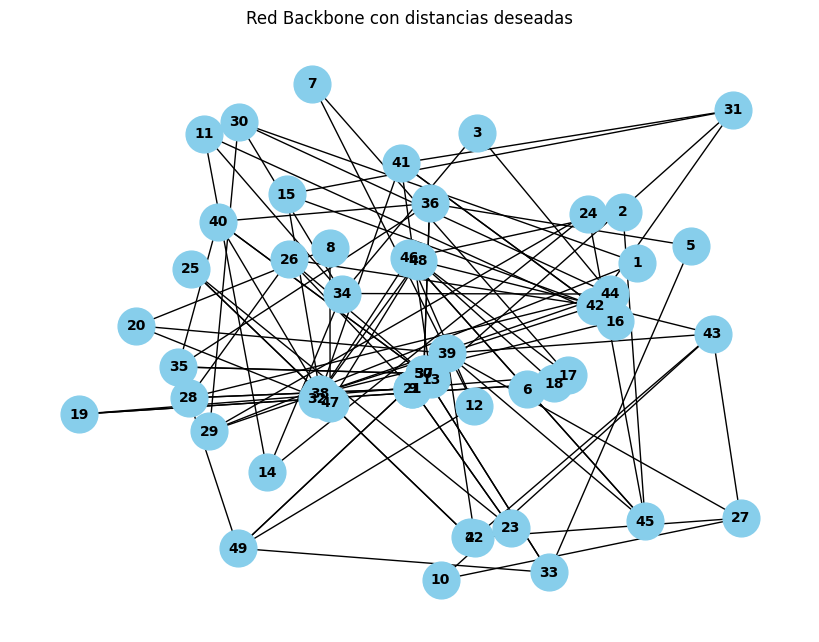

In [ ]:
df5=pd.read_csv("Prueba_50_distancia.csv")
lista = []
lista_distancias = []
aux = 0
num_conexiones = num_total_conexiones/2
for indice, fila in df5.iterrows():
    fila_lista = fila.iloc[0].split(';')
    conexiones = float(fila_lista[0])
    distancias = float(fila_lista[1])
    lista.append(conexiones)
    lista_distancias.append(distancias)


resultado_distancia = ajustar_porcentajes(num_conexiones, lista)

desired_distances = []

for i in range(len(resultado_distancia)):
  desired_distances.extend([lista_distancias[i]] * resultado_distancia[i])


# Creamos posiciones iniciales aleatorias
#initial_pos = np.random.rand(len(G.nodes), 2)

values_pos = list(pos.values())

# Crear una estructura de datos en NumPy
np_pos = np.array(values_pos)

# Minimizamos la función objetivo
edges = list(G.edges())
print(len(desired_distances))
print(len(edges))
# Minimizamos la funcion objetivo, aplanando las posiciones (en un solo plano), metiendo como argumentos las conexiones y las distancias deseadas; y como método L-BFGS-B
# utilizado para problemas de optimizacion
result = minimize(objective, np_pos.flatten(), args=(edges, desired_distances), method='L-BFGS-B')
optimized_pos = result.x.reshape((len(G.nodes), 2)) #Volvemos a ponerlo en dos dimensiones

# Crear un diccionario de posiciones
pos = {i+1: optimized_pos[i] for i in range(len(G.nodes))}

# Función para calcular y devolver las distancias actuales de las aristas
def calculate_edge_distances(G, pos):
    distances = {}
    for u, v in G.edges():
        dist = euclidean(pos[u], pos[v])
        distances[(u, v)] = dist
    return distances

# Calcular las distancias de las aristas
edge_distances = calculate_edge_distances(G, pos)

# Imprimir las distancias calculadas de las aristas
for edge, distance in edge_distances.items():
    print(f"Distancia entre los nodos {edge}: {distance:.2f}")


plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold', edge_color='black')
plt.title("Red Backbone con distancias deseadas")
plt.show()

### **Tipos de Nodos**

[25.0, 12.5, 12.5]
[25, 12, 12]


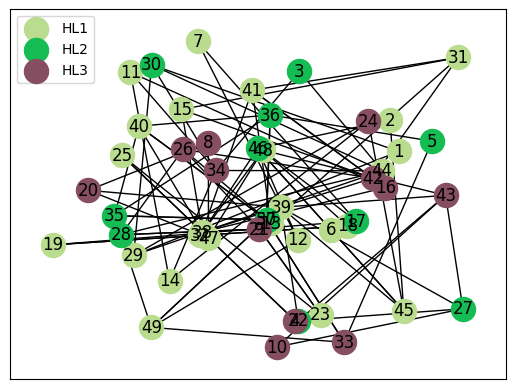

50
[0.5, 0.25, 0.25]
[26, 12, 12]


In [ ]:
df2=pd.read_csv("Prueba_tipoNodo.csv")
lista = []
lista_tipos = []

for indice, fila in df2.iterrows():
    fila_lista = fila.iloc[0].split(';')
    nodos = float(fila_lista[0])
    tipo = fila_lista[1]
    lista.append(nodos)
    lista_tipos.append(tipo)


resultado = ajustar_porcentajes(num_nodos, lista)

# Crear una lista con los tipos de nodos según el número especificado
types_list = []
for node_type, num in zip(lista_tipos, resultado):
    types_list.extend([node_type] * num)


# Mezclar la lista de tipos de nodos aleatoriamente
random.shuffle(types_list)

# Asignar tipos a los nodos
nodes = list(G.nodes())

node_type_dict = {node: types_list[i] for i, node in enumerate(nodes)}

# Definir los colores para cada tipo de nodo
type_colors ={elemento: "#{:06x}".format(random.randint(0, 0xFFFFFF)) for elemento in lista_tipos}

# Dibujar el grafo con los nodos coloreados según su tipo
fig, ax = plt.subplots()

# Dibujar los nodos con los colores asignados
for node_type in lista_tipos:
    node_list = [node for node in nodes if node_type_dict[node] == node_type]
    nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=type_colors[node_type], label=node_type, ax=ax)

# Dibujar las aristas y etiquetas del grafo
nx.draw_networkx_edges(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

# Añadir leyenda
plt.legend()
plt.show()

print(num_nodos)
print(lista)
print(resultado)

### ***Clustering* con Optics**

<ipython-input-144-6836afd50b24>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', max(labels) + 2) #Asignamos los colores con la libreria de matplotlib


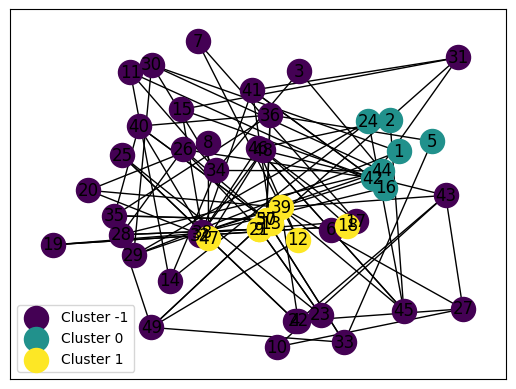

[ 0  0 -1 -1  0 -1 -1 -1  1 -1 -1  1  1 -1 -1  0 -1  1 -1 -1  1 -1 -1  0
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  0 -1  0 -1 -1  1 -1
 -1  1]


In [ ]:
# Necesitamos hacer la matriz de distancias del grafo para poder aplicar el algoritmo

# 1. Creamos una lista con todos los nodos y guardamos su longitud
nodes = list(pos.keys()) # Nos quedamos con el nombre de los nodos
n = len(nodes)

# 2. Creamos una lista con las posiciones de cada nodo
positions = np.array(list(pos.values()))

# 4. Aplicamos el Algoritmo KMeans para la clasificación en Clusters (regiones)
optics = OPTICS(min_samples=0.12, metric='euclidean', cluster_method='dbscan', eps=2)
optics.fit(positions) # Ajustamos el resultado según las distancias
labels = optics.labels_ #Etiquetas -> Indican a que cluster pertenece cada punto

# 5. Asignamos un color a cada Cluster
colors = plt.cm.get_cmap('viridis', max(labels) + 2) #Asignamos los colores con la libreria de matplotlib

# 6. Dibujamos el grafo

for label in np.unique(labels):
    node_list = [nodes[i] for i in range(len(nodes)) if labels[i] == label]
    nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=[colors(label+1)], label=f'Cluster {label}')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

# Leyenda
plt.legend()
plt.show()
print(labels)

### ***Clustering* con Spectral Clustering**

<ipython-input-145-19acca0968c9>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', max(labels) + 1) #Asignamos los colores con la libreria de matplotlib


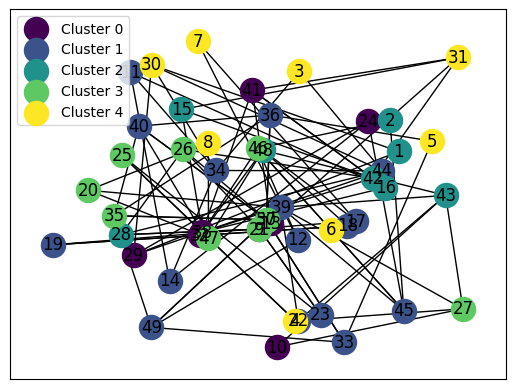

In [ ]:
# 1. Obtenemos la matriz adyacente del grafo
adjacency_matrix = nx.adjacency_matrix(G).todense()

# 2. Aplicamos Spectral Clustering
spectral = SpectralClustering(n_clusters=5, affinity='precomputed')  # Elige el número de clústeres (k)
labels = spectral.fit_predict(adjacency_matrix)

# 3. Asignamos un color a cada Cluster
colors = plt.cm.get_cmap('viridis', max(labels) + 1) #Asignamos los colores con la libreria de matplotlib

# 4. Dibujamos el grafo

for label in np.unique(labels):
    node_list = [nodes[i] for i in range(len(nodes)) if labels[i] == label]
    nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=[colors(label)], label=f'Cluster {label}')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

# Leyenda
plt.legend()
plt.show()

### ***Clustering* con KMeans**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-146-8e8b35f1c122>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', max(labels) + 1) #Asignamos los colores con la libreria de matplotlib


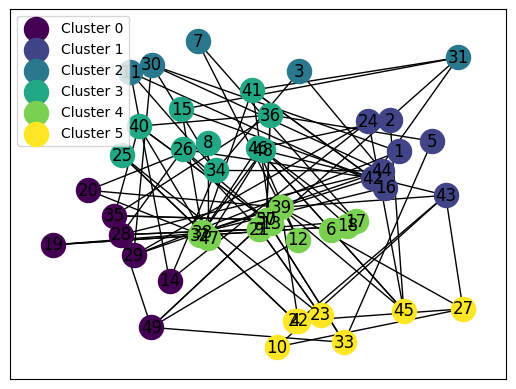

In [ ]:
# Necesitamos hacer la matriz de distancias del grafo para poder aplicar el algoritmo

# 1. Creamos una lista con todos los nodos y guardamos su longitud
nodes = list(pos.keys()) # Nos quedamos con el nombre de los nodos
n = len(nodes)

# 2. Creamos una matriz que guarde todas las distancias del grafo (inicializamos todo a 0)
dist_matrix = np.zeros((n,n)) # Matriz cuadrada nxn

# 3. Hacemos la combinación de cada nodo con todos los nodos
for i in range(n):
    for j in range(n):
        if i != j:
            dist_matrix[i, j] = np.linalg.norm(pos[nodes[i]] - pos[nodes[j]])


# 4. Aplicamos el Algoritmo KMeans para la clasificación en Clusters (regiones)
kmeans = KMeans(n_clusters=6) #Definimos el numero de Clusters
kmeans.fit(dist_matrix) # Ajustamos el resultado según las distancias
labels = kmeans.labels_ #Etiquetas -> Indican a que cluster pertenece cada punto

# 5. Asignamos un color a cada Cluster
colors = plt.cm.get_cmap('viridis', max(labels) + 1) #Asignamos los colores con la libreria de matplotlib

# 6. Dibujamos el grafo

for label in np.unique(labels):
    node_list = [nodes[i] for i in range(len(nodes)) if labels[i] == label]
    nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=[colors(label)], label=f'Cluster {label}')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

# Leyenda
plt.legend()
plt.show()

### **Metro mesh**

Cluster 0

[6.0, 8.0, 6.0]
[6, 8, 6]
[2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 3.]
[1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 3.]
[1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 2.]
[1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 4. 2.]
[1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 2. 2. 3. 3. 3. 3. 3. 3. 2.]
[1. 2. 2. 2. 2. 2. 2. 3. 2. 3. 3. 2. 2. 3. 3. 3. 3. 3. 3. 2.]
[1. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 3. 3. 3. 3. 3. 2. 2.]
[1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 3. 3. 3. 2. 3. 2. 2.]
[1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 3. 3. 3. 2. 3. 2. 2.]
[1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 3. 2. 3. 2. 2.]
[1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 3. 2. 2.]
[1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2.]
[1. 1. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2.]
[1. 1. 1. 0. 1. 1. 2. 2. 2. 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2.]
[0. 1. 1. 0. 1. 1. 1. 2. 2. 2. 1. 1. 2. 1. 2

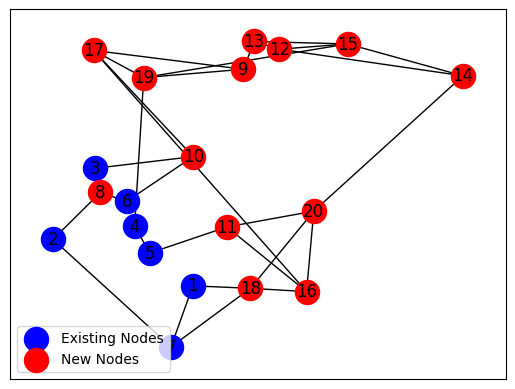

In [ ]:
nodes_mesh_total = 20
df3=pd.read_csv("PruebaCluster.csv")
aux = 0
num_total_conexiones = 0
finish = 0

# Filtramos los nodos que pertenecen a un único cluster
selected_cluster = 0 # Elegimos el cluster
selected_nodes = [nodes[i] for i in range(len(nodes)) if labels[i] == selected_cluster]
selected_pos = {node: pos[node] for node in selected_nodes}

nodes_missing = nodes_mesh_total - len(selected_nodes)

conexiones_pendientes = np.zeros(nodes_mesh_total)
lista_nodos = []
lista_conexiones = []

new_nodes = [f'new_{i}' for i in range(nodes_missing)]

select_node = 0 #Variable para seleccionar nodo con menos conexiones
lista_nodo1 = []
lista_nodo2 = []

#Asignar las conexiones que tiene que hacer cada nodo -> rellenamos la lista conexiones_pendientes
for indice, fila in df3.iterrows():

    fila_lista = fila.iloc[0].split(';')

    nodos = float(fila_lista[0])
    conexiones = int(fila_lista[1])
    lista_nodos.append(nodos)
    lista_conexiones.append(conexiones)


resultado_nodos = ajustar_porcentajes(nodes_mesh_total, lista_nodos)

for i in range(len(resultado_nodos)):
  for j in range(resultado_nodos[i]):
    conexiones_pendientes[j+aux] = lista_conexiones[i]
    num_total_conexiones += lista_conexiones[i]
  aux += resultado_nodos[i]



conexiones_pend  = conexiones_pendientes.copy()
while True:

  distancias = [] #donde vamos a ir almacenando las distancias en una lista de tuplas
  #new_pos = {nodo: np.random.rand(2) for nodo in new_nodes}
  new_pos = {node: 12 * np.random.rand(2) - 6 for node in new_nodes}

  dict_nodes = {**selected_pos, **new_pos}
  all_nodes = selected_nodes + new_nodes
  numeric_nodes = {i+1: dict_nodes[all_nodes[i]] for i in range(nodes_mesh_total)} # ----> Diccionario con todas las posiciones


  existing_nodes_indices = list(range(1, len(selected_nodes) + 1))
  new_nodes_indices = list(range(len(selected_nodes) + 1, nodes_mesh_total + 1))


  lista_pos = list(numeric_nodes.items()) #cambiamos los datos de las posiciones de donde se encuentra cada nodo a lista de tuplas
  conexiones_pendientes = conexiones_pend.copy()
  conexiones_realizadas = [None]*nodes_mesh_total #donde vamos a almacenar los nodos a los que se conecta cada nodo
  G = nx.Graph()


  for l in range(int(num_total_conexiones/2)):
    select_distance = float('inf')
    select = float('inf')
    select_node = 0
    distancias = []

    # 1. Buscamos el nodo con mas conexiones pendientes por hacer
    for i in range(nodes_mesh_total):
      if (conexiones_pendientes[i]>conexiones_pendientes[select_node]):
        select_node = i

    # 2. Recorremos el número total de nodos para rellenar las distancias con ese nodo
    for k in range(nodes_mesh_total):
      if(k!=select_node): #No hacemos la distancia con el mismo nodo
        distancias.append((k+1, np.linalg.norm(lista_pos[select_node][1]-lista_pos[k][1]))) #añadimos la distancia euclidea

    # 3. Recorremos la lista con todas las distancias para elegir el nodo al que conectarse
    for m in range(len(distancias)):
      no = 0
      if ((distancias[m][1] < select_distance) & (distancias[m][1]!=0)): #si la distancia que estamos mirando es menor la seleccionamos
        tupla_buscar = conexiones_realizadas[select_node]
        if(tupla_buscar is not None):
          for n in tupla_buscar:
            if(n==(distancias[m][0]-1)):
              no = 1
        if(conexiones_pendientes[distancias[m][0]-1]==0):
          no = 1

        if ((no==0)):
          select = distancias[m][0] #Seleccionamos el nodo al que nos conectamos
          select_index = m #Antes lo utilizabamos para eliminar de la lista de distancias
          select_distance = distancias[m][1] #Distancia menor seleccionada
          finish=1

    if (finish==1):

      if (conexiones_realizadas[select-1] is not None):
        lista_nodo1 = list(conexiones_realizadas[select-1])
      lista_nodo1.append(select_node)
      tupla1 = tuple(lista_nodo1)
      conexiones_realizadas = list(conexiones_realizadas)
      conexiones_realizadas[select-1] = tupla1

      if (conexiones_realizadas[select_node] is not None):
        lista_nodo2 = list(conexiones_realizadas[select_node])
      lista_nodo2.append(select-1)
      tupla2 = tuple(lista_nodo2)
      conexiones_realizadas = list(conexiones_realizadas)
      conexiones_realizadas[select_node] = tupla2

      conexiones_pendientes[select-1] -=1
      conexiones_pendientes[select_node] -=1
      print(conexiones_pendientes)

      lista_nodo1 = []
      lista_nodo2 = []

      #hacemos la conexion en la gráfica
      G.add_edge(lista_pos[select_node][0], select)
      select_distance = float('inf')
      select = float('inf')
      finish = 0

      distancias = []

  # Cortamos el bucle cuando se hayan hecho todas las conexiones y exista supervivencia
  if ((lista_llena_de_ceros(conexiones_pendientes) == True) & (nx.is_connected(G) == True) & (has_alternative_path_for_each_edge(G) == True) & (has_alternative_path_for_each_node(G) == True)):
    break

# 6. Dibujamos el grafo solo con los nodos y aristas del clúster seleccionado
plt.figure()
nx.draw_networkx_nodes(G, numeric_nodes, nodelist=existing_nodes_indices, node_color='b', label=f'Existing Nodes')
nx.draw_networkx_nodes(G, numeric_nodes, nodelist=new_nodes_indices, node_color='r', label=f'New Nodes')
nx.draw_networkx_edges(G, numeric_nodes)
nx.draw_networkx_labels(G, numeric_nodes)

# Leyenda
plt.legend()
plt.show()

Cluster 1

[6.0, 8.0, 6.0]
[6, 8, 6]
[2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 3. 4. 4.]
[2. 2. 2. 2. 2. 2. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 4. 3. 4. 4.]
[2. 2. 2. 2. 2. 2. 3. 3. 2. 3. 3. 3. 3. 3. 3. 2. 3. 3. 4. 4.]
[2. 2. 1. 2. 2. 2. 3. 3. 2. 3. 3. 3. 3. 3. 3. 2. 3. 3. 3. 4.]
[2. 2. 1. 2. 2. 2. 3. 3. 2. 3. 3. 3. 3. 3. 2. 2. 3. 3. 3. 3.]
[2. 2. 1. 1. 2. 2. 2. 3. 2. 3. 3. 3. 3. 3. 2. 2. 3. 3. 3. 3.]
[2. 2. 1. 1. 2. 1. 2. 2. 2. 3. 3. 3. 3. 3. 2. 2. 3. 3. 3. 3.]
[2. 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 3. 3. 3. 2. 2. 3. 3. 3. 3.]
[2. 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 3. 3. 3. 3.]
[2. 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 3. 3. 3. 3.]
[2. 2. 1. 1. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 3. 3. 3.]
[2. 2. 1. 1. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 3. 2.]
[1. 2. 1. 1. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 2. 2. 2. 2. 1

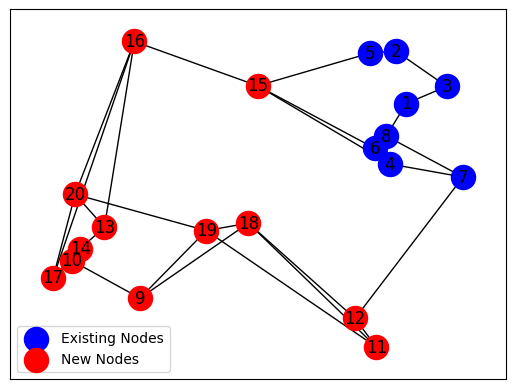

In [ ]:
nodes_mesh_total = 20
df3=pd.read_csv("PruebaCluster.csv")
aux = 0
num_total_conexiones = 0
finish = 0

# Filtramos los nodos que pertenecen a un único cluster
selected_cluster = 1 # Elegimos el cluster
selected_nodes = [nodes[i] for i in range(len(nodes)) if labels[i] == selected_cluster]
selected_pos = {node: pos[node] for node in selected_nodes}

nodes_missing = nodes_mesh_total - len(selected_nodes)

conexiones_pendientes = np.zeros(nodes_mesh_total)
lista_nodos = []
lista_conexiones = []

new_nodes = [f'new_{i}' for i in range(nodes_missing)]

select_node = 0 #Variable para seleccionar nodo con menos conexiones
lista_nodo1 = []
lista_nodo2 = []

#Asignar las conexiones que tiene que hacer cada nodo -> rellenamos la lista conexiones_pendientes
for indice, fila in df3.iterrows():

    fila_lista = fila.iloc[0].split(';')

    nodos = float(fila_lista[0])
    conexiones = int(fila_lista[1])
    lista_nodos.append(nodos)
    lista_conexiones.append(conexiones)


resultado_nodos = ajustar_porcentajes(nodes_mesh_total, lista_nodos)

for i in range(len(resultado_nodos)):
  for j in range(resultado_nodos[i]):
    conexiones_pendientes[j+aux] = lista_conexiones[i]
    num_total_conexiones += lista_conexiones[i]
  aux += resultado_nodos[i]



conexiones_pend  = conexiones_pendientes.copy()
while True:

  distancias = [] #donde vamos a ir almacenando las distancias en una lista de tuplas
  #new_pos = {nodo: np.random.rand(2) for nodo in new_nodes}
  new_pos = {node: 12 * np.random.rand(2) - 6 for node in new_nodes}

  dict_nodes = {**selected_pos, **new_pos}
  all_nodes = selected_nodes + new_nodes
  numeric_nodes = {i+1: dict_nodes[all_nodes[i]] for i in range(nodes_mesh_total)} # ----> Diccionario con todas las posiciones


  existing_nodes_indices = list(range(1, len(selected_nodes) + 1))
  new_nodes_indices = list(range(len(selected_nodes) + 1, nodes_mesh_total + 1))


  lista_pos = list(numeric_nodes.items()) #cambiamos los datos de las posiciones de donde se encuentra cada nodo a lista de tuplas
  conexiones_pendientes = conexiones_pend.copy()
  conexiones_realizadas = [None]*nodes_mesh_total #donde vamos a almacenar los nodos a los que se conecta cada nodo
  G = nx.Graph()


  for l in range(int(num_total_conexiones/2)):
    select_distance = float('inf')
    select = float('inf')
    select_node = 0
    distancias = []

    # 1. Buscamos el nodo con mas conexiones pendientes por hacer
    for i in range(nodes_mesh_total):
      if (conexiones_pendientes[i]>conexiones_pendientes[select_node]):
        select_node = i

    # 2. Recorremos el número total de nodos para rellenar las distancias con ese nodo
    for k in range(nodes_mesh_total):
      if(k!=select_node): #No hacemos la distancia con el mismo nodo
        distancias.append((k+1, np.linalg.norm(lista_pos[select_node][1]-lista_pos[k][1]))) #añadimos la distancia euclidea

    # 3. Recorremos la lista con todas las distancias para elegir el nodo al que conectarse
    for m in range(len(distancias)):
      no = 0
      if ((distancias[m][1] < select_distance) & (distancias[m][1]!=0)): #si la distancia que estamos mirando es menor la seleccionamos
        tupla_buscar = conexiones_realizadas[select_node]
        if(tupla_buscar is not None):
          for n in tupla_buscar:
            if(n==(distancias[m][0]-1)):
              no = 1
        if(conexiones_pendientes[distancias[m][0]-1]==0):
          no = 1

        if ((no==0)):
          select = distancias[m][0] #Seleccionamos el nodo al que nos conectamos
          select_index = m #Antes lo utilizabamos para eliminar de la lista de distancias
          select_distance = distancias[m][1] #Distancia menor seleccionada
          finish=1

    if (finish==1):

      if (conexiones_realizadas[select-1] is not None):
        lista_nodo1 = list(conexiones_realizadas[select-1])
      lista_nodo1.append(select_node)
      tupla1 = tuple(lista_nodo1)
      conexiones_realizadas = list(conexiones_realizadas)
      conexiones_realizadas[select-1] = tupla1

      if (conexiones_realizadas[select_node] is not None):
        lista_nodo2 = list(conexiones_realizadas[select_node])
      lista_nodo2.append(select-1)
      tupla2 = tuple(lista_nodo2)
      conexiones_realizadas = list(conexiones_realizadas)
      conexiones_realizadas[select_node] = tupla2

      conexiones_pendientes[select-1] -=1
      conexiones_pendientes[select_node] -=1
      print(conexiones_pendientes)

      lista_nodo1 = []
      lista_nodo2 = []

      #hacemos la conexion en la gráfica
      G.add_edge(lista_pos[select_node][0], select)
      select_distance = float('inf')
      select = float('inf')
      finish = 0

      distancias = []

  # Cortamos el bucle cuando se hayan hecho todas las conexiones y exista supervivencia
  if ((lista_llena_de_ceros(conexiones_pendientes) == True) & (nx.is_connected(G) == True) & (has_alternative_path_for_each_edge(G) == True) & (has_alternative_path_for_each_node(G) == True)):
    break

# 6. Dibujamos el grafo solo con los nodos y aristas del clúster seleccionado
plt.figure()
nx.draw_networkx_nodes(G, numeric_nodes, nodelist=existing_nodes_indices, node_color='b', label=f'Existing Nodes')
nx.draw_networkx_nodes(G, numeric_nodes, nodelist=new_nodes_indices, node_color='r', label=f'New Nodes')
nx.draw_networkx_edges(G, numeric_nodes)
nx.draw_networkx_labels(G, numeric_nodes)

# Leyenda
plt.legend()
plt.show()

Cluster 2

[6.0, 8.0, 6.0]
[6, 8, 6]
[2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 2. 3. 3. 3. 4. 4. 4. 4. 4.]
[2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 2. 3. 3. 3. 3. 4. 3. 4. 4.]
[2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 2. 3. 2. 3. 3. 3. 3. 4. 4.]
[2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 1. 3. 2. 3. 3. 3. 3. 3. 4.]
[2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 1. 3. 2. 3. 2. 3. 3. 3. 3.]
[2. 2. 2. 2. 1. 2. 2. 3. 3. 3. 3. 1. 3. 2. 3. 2. 3. 3. 3. 3.]
[2. 2. 2. 2. 1. 2. 2. 2. 3. 3. 3. 1. 2. 2. 3. 2. 3. 3. 3. 3.]
[2. 2. 2. 2. 1. 2. 2. 2. 2. 3. 2. 1. 2. 2. 3. 2. 3. 3. 3. 3.]
[2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 3. 2. 3. 3. 3. 3.]
[2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 3. 3. 3. 3.]
[2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 3. 2. 3.]
[2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2.]
[1. 2. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2.]
[0. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2.]
[0. 1. 1. 0. 1. 1. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2.]
[0. 1. 1. 0. 1. 0. 1. 2. 2. 2. 2. 1. 2. 1. 2

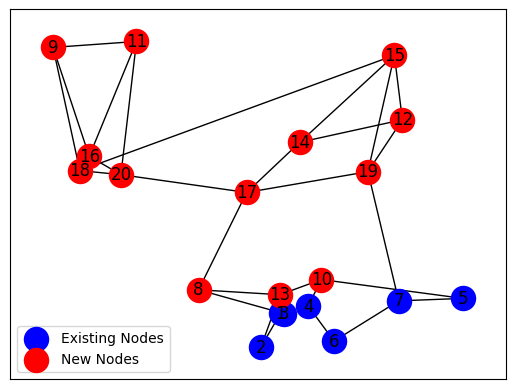

In [ ]:
nodes_mesh_total = 20
df3=pd.read_csv("PruebaCluster.csv")
aux = 0
num_total_conexiones = 0
finish = 0

# Filtramos los nodos que pertenecen a un único cluster
selected_cluster = 5 # Para elegir el  cluster
selected_nodes = [nodes[i] for i in range(len(nodes)) if labels[i] == selected_cluster]
selected_pos = {node: pos[node] for node in selected_nodes}

nodes_missing = nodes_mesh_total - len(selected_nodes)

conexiones_pendientes = np.zeros(nodes_mesh_total)
lista_nodos = []
lista_conexiones = []

new_nodes = [f'new_{i}' for i in range(nodes_missing)]

select_node = 0 #Variable para seleccionar nodo con menos conexiones
lista_nodo1 = []
lista_nodo2 = []

#Asignar las conexiones que tiene que hacer cada nodo -> rellenamos la lista conexiones_pendientes
for indice, fila in df3.iterrows():

    fila_lista = fila.iloc[0].split(';')

    nodos = float(fila_lista[0])
    conexiones = int(fila_lista[1])
    lista_nodos.append(nodos)
    lista_conexiones.append(conexiones)


resultado_nodos = ajustar_porcentajes(nodes_mesh_total, lista_nodos)

for i in range(len(resultado_nodos)):
  for j in range(resultado_nodos[i]):
    conexiones_pendientes[j+aux] = lista_conexiones[i]
    num_total_conexiones += lista_conexiones[i]
  aux += resultado_nodos[i]



conexiones_pend  = conexiones_pendientes.copy()
while True:

  distancias = [] #donde vamos a ir almacenando las distancias en una lista de tuplas
  #new_pos = {nodo: np.random.rand(2) for nodo in new_nodes}
  new_pos = {node: 12 * np.random.rand(2) - 6 for node in new_nodes}

  dict_nodes = {**selected_pos, **new_pos}
  all_nodes = selected_nodes + new_nodes
  numeric_nodes = {i+1: dict_nodes[all_nodes[i]] for i in range(nodes_mesh_total)} # ----> Diccionario con todas las posiciones


  existing_nodes_indices = list(range(1, len(selected_nodes) + 1))
  new_nodes_indices = list(range(len(selected_nodes) + 1, nodes_mesh_total + 1))


  lista_pos = list(numeric_nodes.items()) #cambiamos los datos de las posiciones de donde se encuentra cada nodo a lista de tuplas
  conexiones_pendientes = conexiones_pend.copy()
  conexiones_realizadas = [None]*nodes_mesh_total #donde vamos a almacenar los nodos a los que se conecta cada nodo
  G = nx.Graph()


  for l in range(int(num_total_conexiones/2)):
    select_distance = float('inf')
    select = float('inf')
    select_node = 0
    distancias = []

    # 1. Buscamos el nodo con mas conexiones pendientes por hacer
    for i in range(nodes_mesh_total):
      if (conexiones_pendientes[i]>conexiones_pendientes[select_node]):
        select_node = i

    # 2. Recorremos el número total de nodos para rellenar las distancias con ese nodo
    for k in range(nodes_mesh_total):
      if(k!=select_node): #No hacemos la distancia con el mismo nodo
        distancias.append((k+1, np.linalg.norm(lista_pos[select_node][1]-lista_pos[k][1]))) #añadimos la distancia euclidea

    # 3. Recorremos la lista con todas las distancias para elegir el nodo al que conectarse
    for m in range(len(distancias)):
      no = 0
      if ((distancias[m][1] < select_distance) & (distancias[m][1]!=0)): #si la distancia que estamos mirando es menor la seleccionamos
        tupla_buscar = conexiones_realizadas[select_node]
        if(tupla_buscar is not None):
          for n in tupla_buscar:
            if(n==(distancias[m][0]-1)):
              no = 1
        if(conexiones_pendientes[distancias[m][0]-1]==0):
          no = 1

        if ((no==0)):
          select = distancias[m][0] #Seleccionamos el nodo al que nos conectamos
          select_index = m #Antes lo utilizabamos para eliminar de la lista de distancias
          select_distance = distancias[m][1] #Distancia menor seleccionada
          finish=1

    if (finish==1):

      if (conexiones_realizadas[select-1] is not None):
        lista_nodo1 = list(conexiones_realizadas[select-1])
      lista_nodo1.append(select_node)
      tupla1 = tuple(lista_nodo1)
      conexiones_realizadas = list(conexiones_realizadas)
      conexiones_realizadas[select-1] = tupla1

      if (conexiones_realizadas[select_node] is not None):
        lista_nodo2 = list(conexiones_realizadas[select_node])
      lista_nodo2.append(select-1)
      tupla2 = tuple(lista_nodo2)
      conexiones_realizadas = list(conexiones_realizadas)
      conexiones_realizadas[select_node] = tupla2

      conexiones_pendientes[select-1] -=1
      conexiones_pendientes[select_node] -=1
      print(conexiones_pendientes)

      lista_nodo1 = []
      lista_nodo2 = []

      #hacemos la conexion en la gráfica
      G.add_edge(lista_pos[select_node][0], select)
      select_distance = float('inf')
      select = float('inf')
      finish = 0

      distancias = []

  # Cortamos el bucle cuando se hayan hecho todas las conexiones y exista supervivencia
  if ((lista_llena_de_ceros(conexiones_pendientes) == True) & (nx.is_connected(G) == True) & (has_alternative_path_for_each_edge(G) == True) & (has_alternative_path_for_each_node(G) == True)):
    break

# 6. Dibujamos el grafo solo con los nodos y aristas del clúster seleccionado
plt.figure()
nx.draw_networkx_nodes(G, numeric_nodes, nodelist=existing_nodes_indices, node_color='b', label=f'Existing Nodes')
nx.draw_networkx_nodes(G, numeric_nodes, nodelist=new_nodes_indices, node_color='r', label=f'New Nodes')
nx.draw_networkx_edges(G, numeric_nodes)
nx.draw_networkx_labels(G, numeric_nodes)

# Leyenda
plt.legend()
plt.show()